**About Dataset**: There has been a revenue decline in the Portuguese Bank and they would like to know what actions to take. After investigation, they found that the root cause was that their customers are not investing enough for long term deposits. So the bank would like to identify existing customers that have a higher chance to subscribe for a long term deposit and focus marketing efforts on such customers.

More Information: https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification?datasetId=860138

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Observation

In [ ]:
train_df =  pd.read_csv('new_train.csv')
test_df = pd.read_csv('new_test.csv')

In [ ]:
train_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [ ]:
test_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,32,4,0,6,0,0,0,0,3,3,131,5,1
1,37,10,3,6,0,0,0,0,4,3,100,1,1
2,55,5,0,5,1,2,0,0,3,2,131,2,1
3,44,2,1,0,1,0,0,1,4,3,48,2,1
4,28,0,2,3,0,0,0,0,5,0,144,2,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          8238 non-null   int64
 1   job          8238 non-null   int64
 2   marital      8238 non-null   int64
 3   education    8238 non-null   int64
 4   default      8238 non-null   int64
 5   housing      8238 non-null   int64
 6   loan         8238 non-null   int64
 7   contact      8238 non-null   int64
 8   month        8238 non-null   int64
 9   day_of_week  8238 non-null   int64
 10  duration     8238 non-null   int64
 11  campaign     8238 non-null   int64
 12  poutcome     8238 non-null   int64
dtypes: int64(13)
memory usage: 836.8 KB


# EDA

## Cek target variable

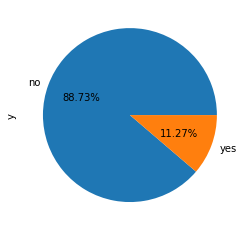

In [ ]:
train_df.y.value_counts().plot.pie(autopct=('%.2f{}'.format('%%')))

In [ ]:
train_df.y.value_counts()

no     29238
yes     3712
Name: y, dtype: int64

## Explore data kategorik

['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'day_of_week' 'poutcome' 'y']


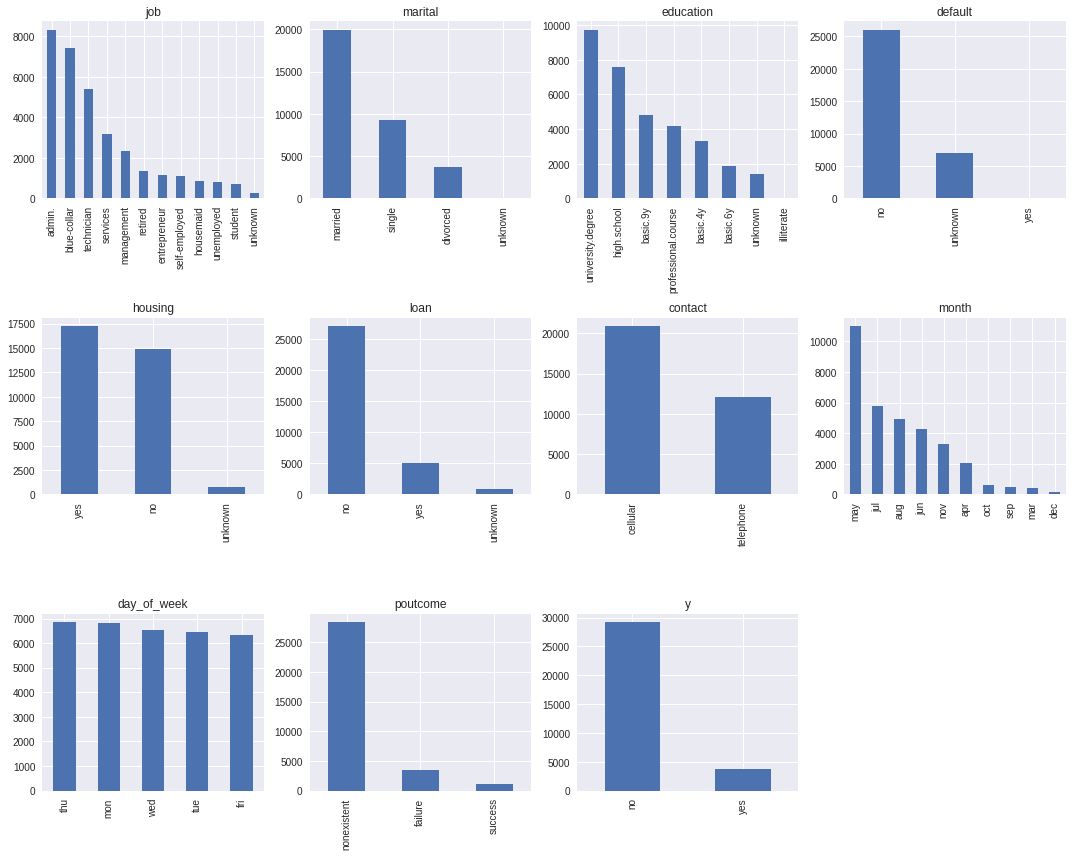

In [ ]:
# Identifikasi variabel kategorik
cat_var = train_df.select_dtypes(include= ["object"]).columns
print(cat_var.values)

# Plot bar chart untuk masing - masing variabel kategorik
plt.style.use("seaborn")
fig, axs = plt.subplots(3, 4, figsize=(15,12))
axs[-1,-1].axis('off')

for i in range(12):
  if i==11:
    break
  ax = axs[i//4, i%4]
  train_df[cat_var.values[i]].value_counts().plot(kind="bar", ax=ax)
  ax.set_title(cat_var.values[i])

plt.tight_layout()
plt.show()

In [ ]:
for i in cat_var:
  print(i, ':', train_df[i].unique())

job : ['blue-collar' 'entrepreneur' 'retired' 'admin.' 'student' 'services'
 'technician' 'self-employed' 'management' 'unemployed' 'unknown'
 'housemaid']
marital : ['married' 'divorced' 'single' 'unknown']
education : ['basic.9y' 'university.degree' 'basic.4y' 'high.school'
 'professional.course' 'unknown' 'basic.6y' 'illiterate']
default : ['unknown' 'no' 'yes']
housing : ['no' 'yes' 'unknown']
loan : ['no' 'yes' 'unknown']
contact : ['cellular' 'telephone']
month : ['nov' 'jul' 'may' 'jun' 'aug' 'mar' 'oct' 'apr' 'sep' 'dec']
day_of_week : ['wed' 'mon' 'tue' 'fri' 'thu']
poutcome : ['nonexistent' 'failure' 'success']
y : ['no' 'yes']


In [ ]:
cat_var.values

array(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome', 'y'], dtype=object)

In [ ]:
for i in cat_var.values[:-1]:
  print(i, ':', test_df[i].unique())

job : [ 4 10  5  2  0  1  6  9  7  8  3 11]
marital : [0 3 1 2]
education : [6 5 0 3 2 7 1 4]
default : [0 1]
housing : [0 2 1]
loan : [0 2 1]
contact : [0 1]
month : [3 4 5 1 7 9 0 6 8 2]
day_of_week : [3 2 0 4 1]
poutcome : [1 0 2]


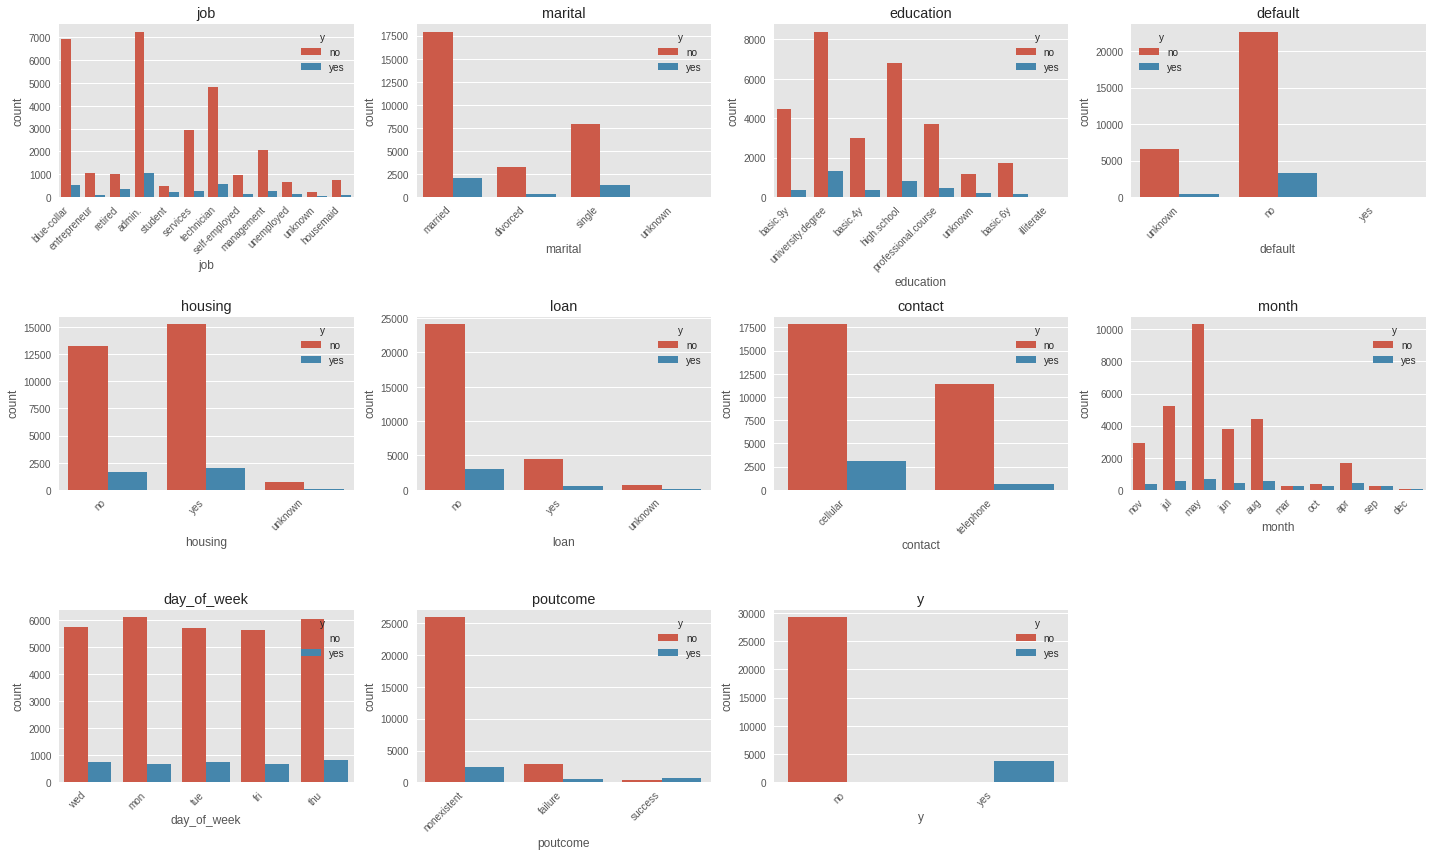

In [ ]:
# Plot bar chart untuk masing - masing variabel kategorik
plt.style.use("ggplot")
fig, axs = plt.subplots(3, 4, figsize=(20,12))
axs[-1,-1].axis('off')

for i in range(12):
  if i==11:
    break
  ax = axs[i//4, i%4]
  sns.countplot(train_df[cat_var.values[i]], hue=train_df["y"], ax=ax)
  ax.set_xticklabels(train_df[cat_var.values[i]].unique(), rotation=45, ha='right')
  ax.set_title(cat_var.values[i])

plt.tight_layout()
plt.show()

## Eksplor data numerik

In [ ]:
# identifikasi data numerik
num_var = train_df.select_dtypes(include=np.int)
num_var.head()

,age,duration,campaign,pdays,previous
0,49,227,4,999,0
1,37,202,2,999,1
2,78,1148,1,999,0
3,36,120,2,999,0
4,59,368,2,999,0


In [ ]:
train_df.drop(['pdays', 'previous'], axis=1, inplace=True)

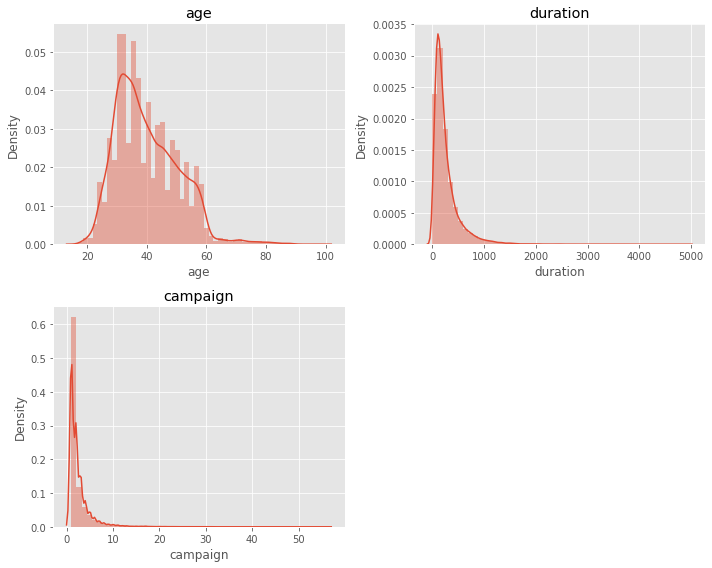

In [ ]:
# Plot histogram untuk masing - masing variabel numerik
plt.style.use("ggplot")
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[-1,-1].axis('off')

for i in range(4):
  if i==3:
    break
  ax = axs[i//2, i%2]
  sns.distplot(train_df[num_var.columns[i]], kde=True, ax=ax)
  ax.set_title(num_var.columns[i])

plt.tight_layout()
plt.show()

In [ ]:
train_df.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,40.014112,258.127466,2.560607
std,10.403636,258.975917,2.752326
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,98.000000,4918.000000,56.000000


# Data Preprocessing

## Handle outlier

In [ ]:
# mengcopy train_df untuk dilakukan preprocessing
train_df_prepared = train_df.copy()
train_df_prepared.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,nonexistent,no


In [ ]:
# menghitung IQR untuk menghitung batas outlier
lower_boundries = []
upper_boundries = []
for i in ["age", "duration", "campaign"]:
  IQR = train_df[i].quantile(0.75) - train_df[i].quantile(0.25)
  lower_bound = train_df[i].quantile(0.25) - (1.5*IQR)
  upper_bound = train_df[i].quantile(0.75) + (1.5*IQR)
  
  print(i, ":", lower_bound, ",",  upper_bound)
  
  lower_boundries.append(lower_bound)
  upper_boundries.append(upper_bound)

age : 9.5 , 69.5
duration : -221.0 , 643.0
campaign : -2.0 , 6.0


In [ ]:
lower_boundries

[9.5, -221.0, -2.0]

In [ ]:
upper_boundries

[69.5, 643.0, 6.0]

In [ ]:
# mengganti nilai outlier dengan nilai batas atas fiturnya
j = 0
for i in ["age", "duration", "campaign"]:
  train_df_prepared.loc[train_df_prepared[i] > upper_boundries[j], i] = int(upper_boundries[j])
  j = j + 1  

In [ ]:
# train_df tanpa outlier
train_df_prepared.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,39.929894,234.923915,2.271077
std,10.118566,176.854558,1.546302
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,69.000000,643.000000,6.000000


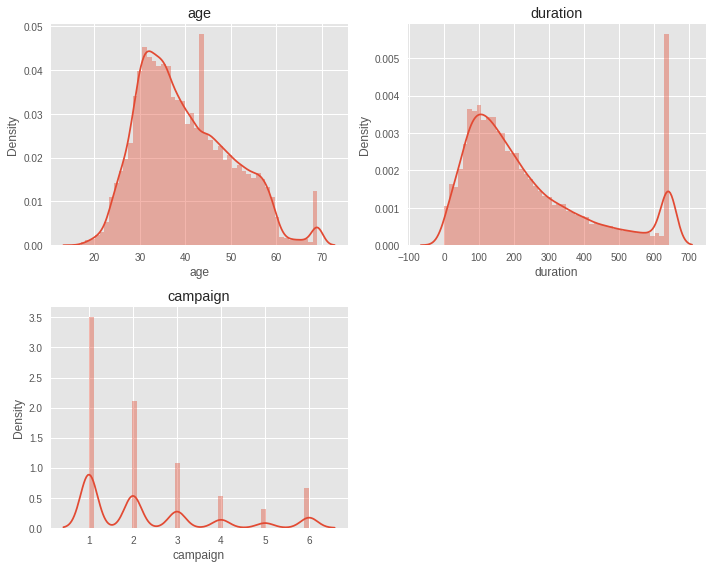

In [ ]:
# plotting bar chart for each numerical variable
plt.style.use("ggplot")
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[-1,-1].axis('off')

for i in range(4):
  if i==3:
    break
  ax = axs[i//2, i%2]
  sns.distplot(train_df_prepared[num_var.columns[i]], kde=True, ax=ax)
  ax.set_title(num_var.columns[i])

plt.tight_layout()
plt.show()

## Encoding data kategorik

In [ ]:
# inisialisasi ordinal encoder
oe = OrdinalEncoder()

train_df_prepared[cat_var] = oe.fit_transform(train_df_prepared[cat_var])

In [ ]:
oe.categories_

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object),
 array(['divorced', 'married', 'single', 'unknown'], dtype=object),
 array(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',
        'professional.course', 'university.degree', 'unknown'],
       dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['cellular', 'telephone'], dtype=object),
 array(['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct',
        'sep'], dtype=object),
 array(['fri', 'mon', 'thu', 'tue', 'wed'], dtype=object),
 array(['failure', 'nonexistent', 'success'], dtype=object),
 array(['no', 'yes'], dtype=object)]

In [ ]:
train_df_prepared

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,1.0,1.0,2.0,1.0,0.0,0.0,0.0,7.0,4.0,227,4,1.0,0.0
1,37,2.0,1.0,6.0,0.0,0.0,0.0,1.0,7.0,4.0,202,2,0.0,0.0
2,69,5.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,643,1,1.0,1.0
3,36,0.0,1.0,6.0,0.0,2.0,0.0,1.0,6.0,1.0,120,2,1.0,0.0
4,59,5.0,0.0,6.0,0.0,0.0,0.0,0.0,4.0,3.0,368,2,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,28,7.0,2.0,3.0,0.0,2.0,0.0,0.0,3.0,3.0,192,1,1.0,0.0
32946,52,9.0,1.0,5.0,0.0,2.0,0.0,0.0,7.0,0.0,64,1,0.0,0.0
32947,54,0.0,1.0,2.0,0.0,0.0,2.0,0.0,3.0,1.0,131,4,1.0,0.0
32948,29,0.0,1.0,6.0,0.0,0.0,0.0,1.0,6.0,0.0,165,1,1.0,0.0


In [ ]:
train_df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          32950 non-null  int64  
 1   job          32950 non-null  float64
 2   marital      32950 non-null  float64
 3   education    32950 non-null  float64
 4   default      32950 non-null  float64
 5   housing      32950 non-null  float64
 6   loan         32950 non-null  float64
 7   contact      32950 non-null  float64
 8   month        32950 non-null  float64
 9   day_of_week  32950 non-null  float64
 10  duration     32950 non-null  int64  
 11  campaign     32950 non-null  int64  
 12  poutcome     32950 non-null  float64
 13  y            32950 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 3.5 MB


In [ ]:
train_df_prepared[cat_var] = train_df_prepared.select_dtypes(include=[np.float64]).values.astype(np.int)

In [ ]:
train_df_prepared.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,1,1,2,1,0,0,0,7,4,227,4,1,0
1,37,2,1,6,0,0,0,1,7,4,202,2,0,0
2,69,5,1,0,0,0,0,0,3,1,643,1,1,1
3,36,0,1,6,0,2,0,1,6,1,120,2,1,0
4,59,5,0,6,0,0,0,0,4,3,368,2,1,0


In [ ]:
train_df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          32950 non-null  int64
 1   job          32950 non-null  int64
 2   marital      32950 non-null  int64
 3   education    32950 non-null  int64
 4   default      32950 non-null  int64
 5   housing      32950 non-null  int64
 6   loan         32950 non-null  int64
 7   contact      32950 non-null  int64
 8   month        32950 non-null  int64
 9   day_of_week  32950 non-null  int64
 10  duration     32950 non-null  int64
 11  campaign     32950 non-null  int64
 12  poutcome     32950 non-null  int64
 13  y            32950 non-null  int64
dtypes: int64(14)
memory usage: 3.5 MB


In [ ]:
# feature variables
X = train_df_prepared.drop('y', axis=1)

# target variable
y = train_df_prepared['y'].copy()

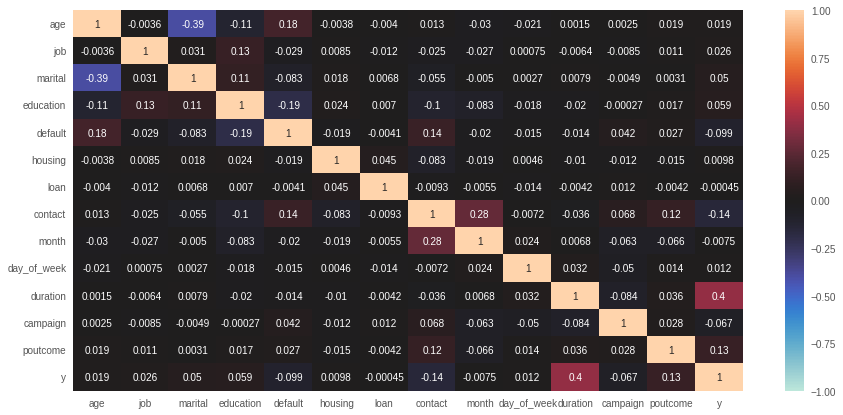

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(train_df_prepared.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

## Scaling data numerik dengan standard scaler














In [ ]:
std_scale = StandardScaler()
X.iloc[:,:] = std_scale.fit_transform(X)
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,0.896396,-0.757779,-0.284871,-0.818379,1.933816,-1.08747,-0.453839,-0.758915,1.192670,1.427938,-0.044805,1.118118,0.193670
1,-0.289561,-0.479529,-0.284871,1.053452,-0.516547,-1.08747,-0.453839,1.317671,1.192670,1.427938,-0.186167,-0.175310,-2.552217
2,2.872991,0.355224,-0.284871,-1.754295,-0.516547,-1.08747,-0.453839,-0.758915,-0.531722,-0.714554,2.307446,-0.822023,0.193670
3,-0.388390,-1.036030,-0.284871,1.053452,-0.516547,0.94245,-0.453839,1.317671,0.761572,-0.714554,-0.649831,-0.175310,0.193670
4,1.884693,0.355224,-1.928167,1.053452,-0.516547,-1.08747,-0.453839,-0.758915,-0.100624,0.713774,0.752472,-0.175310,0.193670
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,-1.179028,0.911725,1.358424,-0.350421,-0.516547,0.94245,-0.453839,-0.758915,-0.531722,0.713774,-0.242711,-0.822023,0.193670
32946,1.192885,1.468227,-0.284871,0.585494,-0.516547,0.94245,-0.453839,-0.758915,1.192670,-1.428718,-0.966481,-0.822023,-2.552217
32947,1.390545,-1.036030,-0.284871,-0.818379,-0.516547,-1.08747,2.304690,-0.758915,-0.531722,-0.714554,-0.587633,1.118118,0.193670
32948,-1.080198,-1.036030,-0.284871,1.053452,-0.516547,-1.08747,-0.453839,1.317671,0.761572,-1.428718,-0.395381,-0.822023,0.193670


## Handle Imbalanced dataset

In [ ]:
# initialising oversampling
smote = SMOTETomek(0.75)

# implementing oversampling to training data
X_sm, y_sm = smote.fit_resample(X, y)

# target class count of resampled dataset
y_sm.value_counts()

0    29106
1    21796
Name: y, dtype: int64

In [ ]:
X_sm

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,0.896396,-0.757779,-0.284871,-0.818379,1.933816,-1.087470,-0.453839,-0.758915,1.192670,1.427938,-0.044805,1.118118,0.193670
1,-0.289561,-0.479529,-0.284871,1.053452,-0.516547,-1.087470,-0.453839,1.317671,1.192670,1.427938,-0.186167,-0.175310,-2.552217
2,2.872991,0.355224,-0.284871,-1.754295,-0.516547,-1.087470,-0.453839,-0.758915,-0.531722,-0.714554,2.307446,-0.822023,0.193670
3,-0.388390,-1.036030,-0.284871,1.053452,-0.516547,0.942450,-0.453839,1.317671,0.761572,-0.714554,-0.649831,-0.175310,0.193670
4,1.884693,0.355224,-1.928167,1.053452,-0.516547,-1.087470,-0.453839,-0.758915,-0.100624,0.713774,0.752472,-0.175310,0.193670
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50897,0.389537,-0.799115,-0.284871,1.053452,-0.516547,0.942450,-0.453839,1.317671,0.266431,-1.018589,1.849586,2.040152,0.193670
50898,-1.070764,-1.036030,1.201553,1.053452,-0.516547,-1.087470,-0.453839,-0.758915,-1.825016,-0.000390,0.364757,1.056382,0.193670
50899,1.891540,0.355224,-0.284871,0.923771,1.933816,-1.087470,-0.453839,-0.758915,-0.591455,1.427938,2.307446,1.675223,0.193670
50900,1.363525,0.810636,-0.284871,-0.733374,-0.516547,0.942450,-0.453839,-0.758915,-1.472228,-0.584826,-0.003368,-0.175310,0.193670


## Split data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((40721, 13), (10181, 13), (40721,), (10181,))

# Modelling

In [ ]:
def build_model(n_neurons=(15,15), learning_rate=3e-3, activation_hidden='relu'):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=[13]))
  for i in range(len(n_neurons)):
    model.add(keras.layers.Dense(n_neurons[i], activation=activation_hidden))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer,
                metrics='accuracy')
  return model

In [ ]:
model = KerasClassifier(build_model, epochs=100, batch_size=200)

Evaluasi model dengan inisialisasi hyperparameter menggunakan "intuisi", yaitu jumlah hidden layer = 2, dengan masing - masing layer memiliki 15 neuron, learning rate = 0.003, activation function untuk hidden layer = relu, epochs = 100, dan batch size = 200.

In [ ]:
cv_mean_accuracy = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

Epoch 1/100
136/136 [==============================] - 1s 2ms/step - loss: 0.4779 - accuracy: 0.7737
Epoch 2/100
136/136 [==============================] - 0s 2ms/step - loss: 0.3969 - accuracy: 0.8178
Epoch 3/100
136/136 [==============================] - 0s 2ms/step - loss: 0.3850 - accuracy: 0.8229
Epoch 4/100
136/136 [==============================] - 0s 2ms/step - loss: 0.3787 - accuracy: 0.8271
Epoch 5/100
136/136 [==============================] - 0s 2ms/step - loss: 0.3748 - accuracy: 0.8307
Epoch 6/100
136/136 [==============================] - 0s 2ms/step - loss: 0.3724 - accuracy: 0.8313
Epoch 7/100
136/136 [==============================] - 0s 2ms/step - loss: 0.3705 - accuracy: 0.8325
Epoch 8/100
136/136 [==============================] - 0s 2ms/step - loss: 0.3679 - accuracy: 0.8336
Epoch 9/100
136/136 [==============================] - 0s 2ms/step - loss: 0.3657 - accuracy: 0.8357
Epoch 10/100
136/136 [==============================] - 0s 2ms/step - loss: 0.3633 - accura

In [ ]:
cv_mean_accuracy

0.8680708990032896

## Grid search untuk hyperparameter tuning

### Hyperparameter tuning jumlah hidden layer dan jumlah neurons

Pertama akan dicari jumlah hidden layer dan jumlah neuron pada hidden layernya yang menghasilkan akurasi terbaik, dengan metode grid search

In [ ]:
params_grid1 = {'n_neurons':[(15,), (15,15), (20,), (20,15), (30,), 
                             (30,20), (50,), (50,30), (70,), (70,50),
                             (100,), (100,70), (130,), (130,100)]}

grid_search1 = GridSearchCV(model, params_grid1, cv=3, scoring='accuracy', 
                           verbose=2)
grid_search1.fit(X_train, y_train, verbose=0)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV] END ....................................n_neurons=(15,); total time=  19.3s
[CV] END ....................................n_neurons=(15,); total time=  21.5s
[CV] END ....................................n_neurons=(15,); total time=  21.4s
[CV] END .................................n_neurons=(15, 15); total time=  21.5s
[CV] END .................................n_neurons=(15, 15); total time=  21.2s
[CV] END .................................n_neurons=(15, 15); total time=  21.3s
[CV] END ....................................n_neurons=(20,); total time=  19.4s
[CV] END ....................................n_neurons=(20,); total time=  21.7s
[CV] END ....................................n_neurons=(20,); total time=  19.3s
[CV] END .................................n_neurons=(20, 15); total time=  21.2s
[CV] END .................................n_neurons=(20, 15); total time=  20.9s
[CV] END .................................n_neur

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe45c1bab90>,
             param_grid={'n_neurons': [(15,), (15, 15), (20,), (20, 15), (30,),
                                       (30, 20), (50,), (50, 30), (70,),
                                       (70, 50), (100,), (100, 70), (130,),
                                       (130, 100)]},
             scoring='accuracy', verbose=2)

In [ ]:
grid_search1.cv_results_['mean_test_score'].max(), grid_search1.best_params_

(0.9106643099130945, {'n_neurons': (130, 100)})

In [ ]:
gs1_result = pd.DataFrame(grid_search1.cv_results_)
gs1_result.sort_values('rank_test_score')[['param_n_neurons', 'mean_test_score', 'rank_test_score']]

,param_n_neurons,mean_test_score,rank_test_score
13,"(130, 100)",0.910664,1
11,"(100, 70)",0.903569,2
9,"(70, 50)",0.893283,3
7,"(50, 30)",0.886188,4
12,"(130,)",0.880689,5
10,"(100,)",0.875338,6
5,"(30, 20)",0.873840,7
8,"(70,)",0.871287,8
6,"(50,)",0.866524,9
3,"(20, 15)",0.866107,10


didapatkan jumlah hidden layer terbaik adalah 2 hidden layer dengan neuron pada hidden layer pertama sejumlah 130 dan neuron pada hidden layer kedua sejumlah 100

### Hyperparameter tuning learning rate dan activation function pada hidden layer

Selanjutnya akan dicari learning rate dan activation function di hidden layer yang akan menghasilkan akurasi terbaik

In [ ]:
params_grid2 = {'n_neurons':[(130,100)],
              'learning_rate':[3e-4, 3e-3, 3e-2],
              'activation_hidden':['relu','sigmoid','tanh']}

grid_search2 = GridSearchCV(model, params_grid2, cv=3, scoring='accuracy', 
                           verbose=2)
grid_search2.fit(X_train, y_train, verbose=0)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END activation_hidden=relu, learning_rate=0.0003, n_neurons=(130, 100); total time=  42.0s
[CV] END activation_hidden=relu, learning_rate=0.0003, n_neurons=(130, 100); total time=  30.3s
[CV] END activation_hidden=relu, learning_rate=0.0003, n_neurons=(130, 100); total time=  30.5s
[CV] END activation_hidden=relu, learning_rate=0.003, n_neurons=(130, 100); total time=  42.0s
[CV] END activation_hidden=relu, learning_rate=0.003, n_neurons=(130, 100); total time=  30.1s
[CV] END activation_hidden=relu, learning_rate=0.003, n_neurons=(130, 100); total time=  31.6s
[CV] END activation_hidden=relu, learning_rate=0.03, n_neurons=(130, 100); total time=  30.4s
[CV] END activation_hidden=relu, learning_rate=0.03, n_neurons=(130, 100); total time=  30.4s
[CV] END activation_hidden=relu, learning_rate=0.03, n_neurons=(130, 100); total time=  42.0s
[CV] END activation_hidden=sigmoid, learning_rate=0.0003, n_neurons=(130, 100); total

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe45c1bab90>,
             param_grid={'activation_hidden': ['relu', 'sigmoid', 'tanh'],
                         'learning_rate': [0.0003, 0.003, 0.03],
                         'n_neurons': [(130, 100)]},
             scoring='accuracy', verbose=2)

In [ ]:
grid_search2.cv_results_['mean_test_score'].max(), grid_search2.best_params_

(0.910443364265724,
 {'activation_hidden': 'tanh',
  'learning_rate': 0.003,
  'n_neurons': (130, 100)})

In [ ]:
gs2_result = pd.DataFrame(grid_search2.cv_results_)
gs2_result.sort_values('rank_test_score')[['param_learning_rate', 
                                           'param_activation_hidden', 
                                           'mean_test_score', 
                                           'rank_test_score']]

,param_learning_rate,param_activation_hidden,mean_test_score,rank_test_score
7,0.003,tanh,0.910443,1
1,0.003,relu,0.908553,2
5,0.03,sigmoid,0.902686,3
4,0.003,sigmoid,0.890755,4
2,0.03,relu,0.888324,5
0,0.0003,relu,0.887981,6
6,0.0003,tanh,0.882825,7
8,0.03,tanh,0.879265,8
3,0.0003,sigmoid,0.826312,9


Didapatkan learning rate dan activation function yang menghasilkan akurasi terbaik adalah 0.003 learning rate dan activation function tanh

### Hyperparameter jumlah epochs dan batch size

Selanjutnya akan dicari jumlah epochs dan batch size yang akan menghasilkan akurasi terbaik

In [ ]:
params_grid3 = {'n_neurons':[(130,100)],
              'learning_rate':[3e-3],
              'activation_hidden':['tanh'],
              'epochs':[100, 200],
              'batch_size':[100,200,350,500]}

grid_search3 = GridSearchCV(model, params_grid3, cv=3, scoring='accuracy', 
                           verbose=2)
grid_search3.fit(X_train, y_train, verbose=0)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END activation_hidden=tanh, batch_size=100, epochs=100, learning_rate=0.003, n_neurons=(130, 100); total time= 1.4min
[CV] END activation_hidden=tanh, batch_size=100, epochs=100, learning_rate=0.003, n_neurons=(130, 100); total time= 1.4min
[CV] END activation_hidden=tanh, batch_size=100, epochs=100, learning_rate=0.003, n_neurons=(130, 100); total time= 1.4min
[CV] END activation_hidden=tanh, batch_size=100, epochs=200, learning_rate=0.003, n_neurons=(130, 100); total time= 1.7min
[CV] END activation_hidden=tanh, batch_size=100, epochs=200, learning_rate=0.003, n_neurons=(130, 100); total time= 1.7min
[CV] END activation_hidden=tanh, batch_size=100, epochs=200, learning_rate=0.003, n_neurons=(130, 100); total time= 2.4min
[CV] END activation_hidden=tanh, batch_size=200, epochs=100, learning_rate=0.003, n_neurons=(130, 100); total time=  32.6s
[CV] END activation_hidden=tanh, batch_size=200, epochs=100, learning_rate=0.00

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe45c1bab90>,
             param_grid={'activation_hidden': ['tanh'],
                         'batch_size': [100, 200, 350, 500],
                         'epochs': [100, 200], 'learning_rate': [0.003],
                         'n_neurons': [(130, 100)]},
             scoring='accuracy', verbose=2)

In [ ]:
grid_search3.cv_results_['mean_test_score'].max(), grid_search3.best_params_

(0.9141503412382775,
 {'activation_hidden': 'tanh',
  'batch_size': 500,
  'epochs': 100,
  'learning_rate': 0.003,
  'n_neurons': (130, 100)})

In [ ]:
gs3_result = pd.DataFrame(grid_search3.cv_results_)
gs3_result.sort_values('rank_test_score')[['param_epochs', 'param_batch_size', 'mean_test_score', 'rank_test_score']]

,param_epochs,param_batch_size,mean_test_score,rank_test_score
6,100,500,0.914150,1
4,100,350,0.913610,2
7,200,500,0.913144,3
3,200,200,0.912260,4
5,200,350,0.911131,5
2,100,200,0.910517,6
0,100,100,0.910296,7
1,200,100,0.908578,8


didapatkan epochs dan batch size yang menghasilkan akurasi terbaik adalah sebanyak 100 epochs dan 500 batch size, yaitu menghasilkan akurasi mencapai 0.91

## Evaluasi model pada Validation Data

Selanjutnya, dengan hyperparameter terbaik yang didapat menggunakan grid search, model akan dievaluasi menggunakan validation data

In [ ]:
model = grid_search3.best_estimator_
model.fit(X_train, y_train, validation_data=(X_val, y_val))

Epoch 1/100
82/82 [==============================] - 1s 8ms/step - loss: 0.4483 - accuracy: 0.7946 - val_loss: 0.4095 - val_accuracy: 0.8173
Epoch 2/100
82/82 [==============================] - 0s 5ms/step - loss: 0.3949 - accuracy: 0.8233 - val_loss: 0.3784 - val_accuracy: 0.8330
Epoch 3/100
82/82 [==============================] - 0s 6ms/step - loss: 0.3744 - accuracy: 0.8342 - val_loss: 0.3664 - val_accuracy: 0.8368
Epoch 4/100
82/82 [==============================] - 0s 5ms/step - loss: 0.3612 - accuracy: 0.8404 - val_loss: 0.3525 - val_accuracy: 0.8446
Epoch 5/100
82/82 [==============================] - 0s 5ms/step - loss: 0.3478 - accuracy: 0.8474 - val_loss: 0.3458 - val_accuracy: 0.8471
Epoch 6/100
82/82 [==============================] - 0s 5ms/step - loss: 0.3329 - accuracy: 0.8552 - val_loss: 0.3325 - val_accuracy: 0.8590
Epoch 7/100
82/82 [==============================] - 0s 6ms/step - loss: 0.3206 - accuracy: 0.8617 - val_loss: 0.3176 - val_accuracy: 0.8637
Epoch 8/100
8

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      5865
           1       0.89      0.95      0.92      4315

    accuracy                           0.93     10180
   macro avg       0.93      0.93      0.93     10180
weighted avg       0.93      0.93      0.93     10180



Didapatkan akurasi dan f1 score yang cukup bagus, sehingga akan dipakai model tersebut

## Cek fitur yang paling mempengaruhi akurasi

Selanjutnya akan dicek fitur yang mempengaruhi akurasi model menggunakan metode Permutation Importance

In [ ]:
result = permutation_importance(model, X_val, y_val, n_repeats=10,
                                scoring='accuracy', random_state=42)

In [ ]:
for i in result.importances_mean.argsort()[::-1]:
  print(f"{X_val.columns.values[i]:<12}"
        f"{result.importances_mean[i]:.3f}"
        f" +/- {result.importances_std[i]:.3f}")

duration    0.247 +/- 0.004
month       0.137 +/- 0.003
age         0.111 +/- 0.003
poutcome    0.088 +/- 0.002
education   0.083 +/- 0.002
job         0.083 +/- 0.001
day_of_week 0.075 +/- 0.003
marital     0.073 +/- 0.002
contact     0.072 +/- 0.002
campaign    0.070 +/- 0.002
housing     0.063 +/- 0.003
default     0.042 +/- 0.002
loan        0.037 +/- 0.002


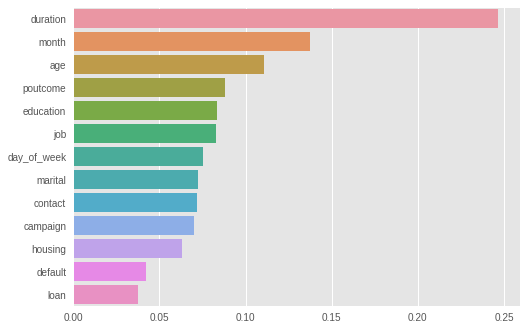

In [ ]:
result_sorted = []
columns_sorted = []

for res, col in sorted(zip(result.importances_mean, X_val.columns.values), reverse=True):
  result_sorted.append(res)
  columns_sorted.append(col)

sns.barplot(result_sorted, columns_sorted)
plt.show()

In [ ]:
train_df_yes = train_df.loc[train_df['y']=='yes',:]

train_df_yes[['duration', 'age']].describe()

,duration,age
count,3712.000000,3712.000000
mean,549.398976,40.851293
std,397.490060,13.760020
min,63.000000,17.000000
25%,252.000000,31.000000
50%,448.000000,37.000000
75%,737.000000,50.000000
max,4199.000000,98.000000


In [ ]:
train_df_yes[['month']].describe()

,month
count,3712
unique,10
top,may
freq,699


Tiga feature yang paling berpengaruh pada akurasi model adalah duration, month, dan age. Dimana, rata - rata durasi telepon yang dilakukan pada customer yang mau untuk melakukan deposit jangka panjang adalah selama 549 detik, umur customer rata - rata 40, dan telepon dilakukan paling banyak pada bulan mei

## Simpan dan Training model final pada keseluruhan data training

In [ ]:
# Simpan model terbaik dalam final_model
final_model = build_model(n_neurons=(130,100), activation_hidden='tanh',
                          learning_rate=3e-3)

In [ ]:
history = final_model.fit(X_sm, y_sm, epochs=100, batch_size=500)

Epoch 1/100
102/102 [==============================] - 1s 5ms/step - loss: 0.4318 - accuracy: 0.8021
Epoch 2/100
102/102 [==============================] - 0s 5ms/step - loss: 0.3821 - accuracy: 0.8295
Epoch 3/100
102/102 [==============================] - 0s 5ms/step - loss: 0.3671 - accuracy: 0.8352
Epoch 4/100
102/102 [==============================] - 1s 5ms/step - loss: 0.3492 - accuracy: 0.8446
Epoch 5/100
102/102 [==============================] - 1s 5ms/step - loss: 0.3291 - accuracy: 0.8566
Epoch 6/100
102/102 [==============================] - 1s 5ms/step - loss: 0.3132 - accuracy: 0.8663
Epoch 7/100
102/102 [==============================] - 0s 5ms/step - loss: 0.3026 - accuracy: 0.8714
Epoch 8/100
102/102 [==============================] - 0s 5ms/step - loss: 0.2923 - accuracy: 0.8766
Epoch 9/100
102/102 [==============================] - 0s 4ms/step - loss: 0.2878 - accuracy: 0.8788
Epoch 10/100
102/102 [==============================] - 0s 5ms/step - loss: 0.2781 - accura

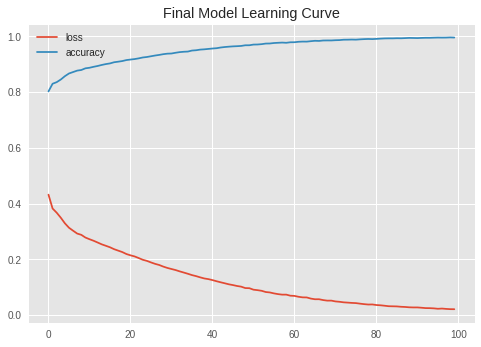

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Final Model Learning Curve')
plt.show()

In [ ]:
output_weights, output_bias = final_model.layers[-1].get_weights()
print('Weights and bias in output layer')
print('WEIGHTS:')
for i,j in zip([0 for _ in range(100)], range(100)):
  print('w{0},{1} = {2:.5f}'.format(i, j, output_weights[j,0]))

print('BIAS:')
print(output_bias[0])

Weights and bias in output layer
WEIGHTS:
w0,0 = -1.11093
w0,1 = -0.00857
w0,2 = -0.94616
w0,3 = 1.34372
w0,4 = 1.51600
w0,5 = -1.21107
w0,6 = -1.51578
w0,7 = -1.86109
w0,8 = -1.60558
w0,9 = -0.00265
w0,10 = -1.77840
w0,11 = -1.72525
w0,12 = -1.35757
w0,13 = 1.70137
w0,14 = -1.23597
w0,15 = -2.14601
w0,16 = 1.58081
w0,17 = -0.71141
w0,18 = -1.69359
w0,19 = 1.53254
w0,20 = -1.95112
w0,21 = 1.28793
w0,22 = 1.72001
w0,23 = -1.11841
w0,24 = -0.00328
w0,25 = 1.38639
w0,26 = 1.16780
w0,27 = 1.68104
w0,28 = -1.26061
w0,29 = -1.60047
w0,30 = -1.56888
w0,31 = 1.37486
w0,32 = 1.40079
w0,33 = 1.96749
w0,34 = 1.26676
w0,35 = -1.43022
w0,36 = 1.53469
w0,37 = 1.44282
w0,38 = -1.74922
w0,39 = 1.24851
w0,40 = 1.84118
w0,41 = -1.41191
w0,42 = 1.35023
w0,43 = -1.85489
w0,44 = -2.28187
w0,45 = -1.64699
w0,46 = -1.76662
w0,47 = 1.12286
w0,48 = 1.88586
w0,49 = 1.53770
w0,50 = -1.92407
w0,51 = -2.04491
w0,52 = -1.43550
w0,53 = 1.37810
w0,54 = 1.50191
w0,55 = -1.82019
w0,56 = 1.85901
w0,57 = -0.00824
w0,58 =

In [ ]:
# simpan model ke .pkl
import joblib
joblib.dump(final_model, 'neural_network_model.pkl')

INFO:tensorflow:Assets written to: ram://2a0fd530-4d92-4f87-8b28-bdd540ec44e3/assets


['neural_network_model.pkl']

#Prediksi test data

In [ ]:
test_prepared = std_scale.transform(test_df)
test_df_prepared = pd.DataFrame(test_prepared, columns=X_sm.columns)
test_df_prepared

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,-0.783709,0.076973,-1.928167,1.053452,-0.516547,-1.08747,-0.453839,-0.758915,-0.531722,0.713774,-0.587633,1.764832,0.193670
1,-0.289561,1.746477,3.001720,1.053452,-0.516547,-1.08747,-0.453839,-0.758915,-0.100624,0.713774,-0.762920,-0.822023,0.193670
2,1.489375,0.355224,-1.928167,0.585494,1.933816,0.94245,-0.453839,-0.758915,-0.531722,-0.000390,-0.587633,-0.175310,0.193670
3,0.402247,-0.479529,-0.284871,-1.754295,1.933816,-1.08747,-0.453839,1.317671,-0.100624,0.713774,-1.056952,-0.175310,0.193670
4,-1.179028,-1.036030,1.358424,-0.350421,-0.516547,-1.08747,-0.453839,-0.758915,0.330474,-1.428718,-0.514125,-0.175310,0.193670
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,0.797566,0.076973,-0.284871,-0.818379,-0.516547,0.94245,-0.453839,-0.758915,0.761572,0.713774,1.804200,-0.822023,0.193670
8234,-0.981369,0.911725,1.358424,-0.350421,-0.516547,0.94245,-0.453839,-0.758915,0.761572,-1.428718,-0.429308,-0.822023,0.193670
8235,-0.684880,0.911725,-0.284871,-0.350421,-0.516547,-1.08747,-0.453839,-0.758915,-0.100624,-0.714554,1.340535,-0.822023,-2.552217
8236,0.402247,-0.757779,-0.284871,-1.286337,-0.516547,0.94245,2.304690,1.317671,0.761572,-0.714554,1.804200,1.764832,0.193670


In [ ]:
y_pred_proba = final_model.predict(test_df_prepared)
y_pred_proba

array([[5.9601532e-13],
       [3.5414100e-04],
       [3.7234050e-14],
       ...,
       [9.9776506e-01],
       [2.3004431e-01],
       [2.0830016e-16]], dtype=float32)

In [ ]:
y_pred = (y_pred_proba >= 0.5).astype(np.int)
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [ ]:
test_df['y_prediction'] = y_pred

In [ ]:
test_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y_prediction
0,32,4,0,6,0,0,0,0,3,3,131,5,1,0
1,37,10,3,6,0,0,0,0,4,3,100,1,1,0
2,55,5,0,5,1,2,0,0,3,2,131,2,1,0
3,44,2,1,0,1,0,0,1,4,3,48,2,1,0
4,28,0,2,3,0,0,0,0,5,0,144,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,48,4,1,2,0,2,0,0,6,3,554,1,1,0
8234,30,7,2,3,0,2,0,0,6,0,159,1,1,0
8235,33,7,1,3,0,0,0,0,4,1,472,1,0,1
8236,44,1,1,1,0,2,2,1,6,1,554,5,1,0


In [ ]:
test_df.y_prediction.value_counts()

0    7360
1     878
Name: y_prediction, dtype: int64

In [ ]:
test_df.to_csv('test_prediction.csv', index=False)